<a href="https://colab.research.google.com/github/abhi220501/EE769-Cource-Project/blob/main/ml_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/dataset_defo.zip

In [ ]:
pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsampler import ImbalancedDatasetSampler

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/dataset_defo/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],sampler=ImbalancedDatasetSampler(image_datasets[x]), batch_size=4, 
                                              num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


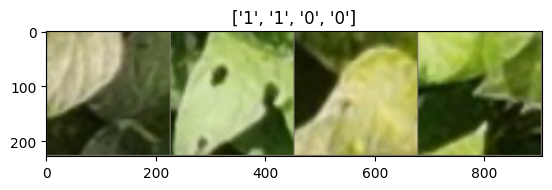

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.05)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_densenet121_20_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
# 7 - 12 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=6)

Epoch 0/5
----------
train Loss: 0.5507 Acc: 0.7070
test Loss: 0.4416 Acc: 0.7869

Epoch 1/5
----------
train Loss: 0.5532 Acc: 0.7028
test Loss: 0.4574 Acc: 0.7656

Epoch 2/5
----------
train Loss: 0.5553 Acc: 0.7021
test Loss: 0.4518 Acc: 0.7725

Epoch 3/5
----------
train Loss: 0.5557 Acc: 0.6996
test Loss: 0.4397 Acc: 0.7836

Epoch 4/5
----------
train Loss: 0.5516 Acc: 0.7059
test Loss: 0.4359 Acc: 0.7886

Epoch 5/5
----------
train Loss: 0.5539 Acc: 0.7031
test Loss: 0.4500 Acc: 0.7762

Training complete in 71m 0s
Best val Acc: 0.788603


In [ ]:
# 13-20 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.5527 Acc: 0.7031
test Loss: 0.4437 Acc: 0.7756

Epoch 1/7
----------
train Loss: 0.5505 Acc: 0.7053
test Loss: 0.4494 Acc: 0.7747

Epoch 2/7
----------
train Loss: 0.5518 Acc: 0.7023
test Loss: 0.4426 Acc: 0.7884

Epoch 3/7
----------
train Loss: 0.5530 Acc: 0.7028
test Loss: 0.4403 Acc: 0.7835

Epoch 4/7
----------
train Loss: 0.5562 Acc: 0.7000
test Loss: 0.4474 Acc: 0.7830

Epoch 5/7
----------
train Loss: 0.5522 Acc: 0.7031
test Loss: 0.4447 Acc: 0.7821

Epoch 6/7
----------
train Loss: 0.5561 Acc: 0.7018
test Loss: 0.4348 Acc: 0.7892

Epoch 7/7
----------
train Loss: 0.5524 Acc: 0.7045
test Loss: 0.4562 Acc: 0.7721

Training complete in 94m 60s
Best val Acc: 0.789190


In [ ]:
model_conv.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_conv.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_conv.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_conv.state_dict(),
                  'class_to_idx': model_conv.class_to_idx,
                  'epoch': model_conv.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_densenet121_20_withIDS.pth')

In [ ]:
# TRAINING THE WHOLE MODEL NOW...


In [ ]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
from collections import OrderedDict

model_ft.classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 512)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu', nn.ReLU()),
    ('fc3', nn.Linear(256, 2)),
]))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.05)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]


In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_densenet121_ft_6_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
# 7 to 12 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.3617 Acc: 0.8154
test Loss: 0.3231 Acc: 0.8595

Epoch 1/5
----------
train Loss: 0.3654 Acc: 0.8140
test Loss: 0.3771 Acc: 0.8479

Epoch 2/5
----------
train Loss: 0.3642 Acc: 0.8136
test Loss: 0.3202 Acc: 0.8571

Epoch 3/5
----------
train Loss: 0.3648 Acc: 0.8149
test Loss: 0.4162 Acc: 0.8297

Epoch 4/5
----------
train Loss: 0.3637 Acc: 0.8141
test Loss: 0.3343 Acc: 0.8571

Epoch 5/5
----------
train Loss: 0.3632 Acc: 0.8153
test Loss: 0.3328 Acc: 0.8552

Training complete in 164m 20s
Best val Acc: 0.859493


In [ ]:
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 12
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_densenet121_ft_12_withIDS.pth')

In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_densenet121_ft_12_withIDS.pth')
model_ft.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_ft.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
# 13 to 20 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------
train Loss: 0.3659 Acc: 0.8136
test Loss: 0.3257 Acc: 0.8615

Epoch 1/7
----------
train Loss: 0.3638 Acc: 0.8140
test Loss: 0.3480 Acc: 0.8528

Epoch 2/7
----------
train Loss: 0.3645 Acc: 0.8117
test Loss: 0.3183 Acc: 0.8523

Epoch 3/7
----------
train Loss: 0.3667 Acc: 0.8118
test Loss: 0.3549 Acc: 0.8462

Epoch 4/7
----------
train Loss: 0.3647 Acc: 0.8134
test Loss: 0.3370 Acc: 0.8547

Epoch 5/7
----------
train Loss: 0.3666 Acc: 0.8137
test Loss: 0.3460 Acc: 0.8499

Epoch 6/7
----------
train Loss: 0.3652 Acc: 0.8134
test Loss: 0.3717 Acc: 0.8357

Epoch 7/7
----------
train Loss: 0.3632 Acc: 0.8138
test Loss: 0.3591 Acc: 0.8452

Training complete in 229m 36s
Best val Acc: 0.861549


In [ ]:
model_ft.class_to_idx = dataloaders['train'].dataset.class_to_idx
model_ft.epochs = 20
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model_ft.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer_ft.state_dict(),
                  'class_to_idx': model_ft.class_to_idx,
                  'epoch': model_ft.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/Saved_models/soyabean_densenet121_ft_20_withIDS.pth')

In [ ]:
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
#Testing
from torch.autograd import Variable

def test(model, dataloaders, device):
    model.eval()
    accuracy = 0
      
    preds = []
    actual = []
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        images, labels = images.to(device), labels.to(device)
          
        output = model.forward(images)
        ps = torch.exp(output)
        preds.append(np.array(ps.max(1)[1].cpu()))
        actual.append(np.array(labels.data.cpu()))
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    preds = np.array(preds, dtype=object)
    actual = np.array(actual, dtype=object)
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))
    return np.concatenate(preds), np.concatenate(actual)

In [ ]:
loaded_checkpoint = torch.load('/content/drive/MyDrive/Saved_models/soyabean_densenet121_20_withIDS.pth')
model_conv.load_state_dict(loaded_checkpoint['state_dict'])
optimizer_conv.load_state_dict(loaded_checkpoint['optimizer_dict'])

In [ ]:
#ONLY CONV NET
preds_conv, actual_conv = test(model_conv, dataloaders, device)
preds_conv

Testing Accuracy: 0.785


array([0, 1, 1, ..., 0, 0, 1])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

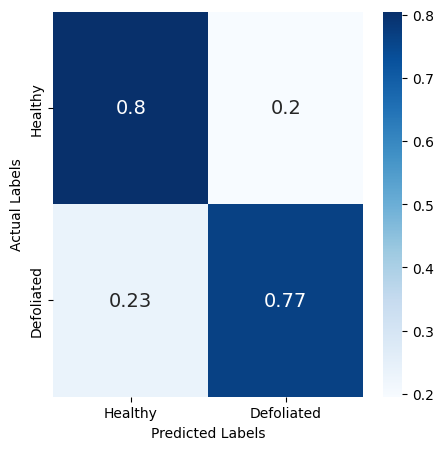

In [ ]:
#For fine tuned on conv net only
cm = confusion_matrix(preds_conv, actual_conv, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#Fine tuning on conv net

print(f1_score(actual_conv, preds_conv, average="binary"))
print(precision_score(actual_conv, preds_conv, average="binary"))
print(recall_score(actual_conv, preds_conv, average="binary"))  

0.7892316535734815
0.7664681801265352
0.8133886255924171


In [ ]:
#FULLY TRAINED
preds, actual = test(model_ft, dataloaders, device)
preds

Testing Accuracy: 0.851


array([1, 0, 0, ..., 1, 1, 1])

[Text(0.5, 25.722222222222214, 'Predicted Labels'),
 Text(33.222222222222214, 0.5, 'Actual Labels')]

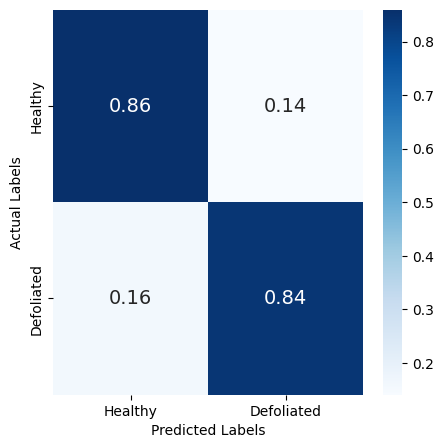

In [ ]:

cm = confusion_matrix(preds, actual, normalize='true')
df_cm = pd.DataFrame(cm, index = ['Healthy', 'Defoliated'], 
                     columns = ['Healthy', 'Defoliated'])

plt.figure(figsize=(5, 5))
s = sns.heatmap(df_cm, annot=True, cmap="Blues", 
            annot_kws={
                'fontsize': 14
            })
s.set(xlabel='Predicted Labels', ylabel='Actual Labels')

In [ ]:
#For fully trained


print(f1_score(actual, preds, average="binary"))
print(precision_score(actual, preds, average="binary"))
print(recall_score(actual, preds, average="binary"))  

0.8520066077154796
0.8424289008455035
0.8618045999606841
